In [1]:
import numpy as np
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
from collections import defaultdict
import copy
%matplotlib inline

In [2]:
from helpers.convert_to_var_foo import convert_to_var
from helpers.create_empty_directory import create_empty_directory
from helpers.replay_buffer import ReplayBuffer
from tabular_environments.chain_environment import SimpleChain

In [3]:
from qlearning.train import train_with_e_learning
from qlearning.q_loss import sarsa_loss
from qlearning.models import Qnet, Enet

In [4]:
dim = 5
env = SimpleChain(dim)
model = Qnet(env.action_space.n,
               env.observation_space.shape[0],
               hidden_size=128, num_hidden=1,
               set_weights=False)

eps_params = {'exploration_fraction': 0.25,
              'exploration_final_eps': 0.01}

params = dict(gamma=0.99, gamma_E=0.9, write_logs=False,
              target_type='standard_q_learning', eps_params=eps_params,
              lr=1e-4, e_lr=1e-4, act_type='epsilon_greedy')

    
e_model = Enet(env.action_space.n,
               env.observation_space.shape[0],
               hidden_size=512, num_hidden=2)

trajectory_path = 'example_trajectories/chain_{}'.format(dim)
create_empty_directory(trajectory_path)
max_num_episodes = 1000

rews, num_episodes = train_with_e_learning(env, model, e_model,
                           seed=42,
                           replay_buffer_size=1e+5,
                           batch_size=64,
                           learning_starts_in_steps=250,
                           max_steps=(dim+9)*max_num_episodes,
                           max_num_episodes=max_num_episodes,
                           train_freq_in_steps=5,
                           update_freq_in_steps=100,
                           print_freq=None,
                           do_pretraining=True,
                           chain_criterion=True,
                           **params,
                           return_trajectory=True,
                           trajectory_path=trajectory_path)


schedule_timesteps 250


In [5]:
states = np.load(trajectory_path+'/_states.npy')
actions = np.load(trajectory_path+'/_actions.npy')
rewards = np.load(trajectory_path+'/_rewards.npy')
dones = np.load(trajectory_path+'/_dones.npy')
next_states = np.load(trajectory_path+'/_next_states.npy')
next_actions = np.load(trajectory_path+'/_next_actions.npy')

In [6]:
trajectory_len = len(states)

In [7]:
trajectory = (states.sum(axis=1)-1).astype('int64')
real_counters = np.zeros((trajectory_len, dim))

real_counters[0][trajectory[0]] = 1

for i in range(1, trajectory_len):
    s = trajectory[i]
    
    for j in range(dim):
        if s == j:
            real_counters[i][j] = real_counters[i-1][j] + 1
        else:
            real_counters[i][j] = real_counters[i-1][j]

In [8]:
update_freq = 50
train_freq =5
gamma_E = 0.9
batch_size = 64

replay_buffer = ReplayBuffer(1e+3, seed=42)

e_model = Enet(env.action_space.n,
               1, #env.observation_space.shape[0],
               hidden_size=512, num_hidden=2)
target_e_model = copy.deepcopy(e_model)

e_lr = 1e-4
e_optimizer = torch.optim.Adam(e_model.parameters(), e_lr)


e_counters = []
all_states  = env.get_all_states()
for i in range(1, 10):
    state = states[i-1].sum(keepdims=True)-1
    action = actions[i-1]
    rew = rewards[i-1]
    done = dones[i-1]
    next_state = next_states[i].sum(keepdims=True)-1
    next_action = next_actions[i]
    
    ### one step ###
    if state == 0:
        batch = [np.array([state]), np.array([action]), np.array([rew]),
                             np.array([done]), np.array([next_state]), np.array([next_action])]
        e_loss = sarsa_loss(e_optimizer, e_model, target_e_model, batch, gamma_E)
    ################
    
    e_values = convert_to_var(all_states)
    if torch.cuda.is_available():
        e_values = e_model.forward(convert_to_var(all_states.sum(axis=1, keepdims=True)-1)).cpu().data.numpy()
    else:
        e_values = e_model.forward(convert_to_var(all_states.sum(axis=1, keepdims=True)-1)).data.numpy()
        print(e_values)
        print()
        
    cnt = np.log(e_values) / np.log(1 - e_lr) + np.log(2) / np.log(1-e_lr)
    e_counters.append(cnt.sum(axis=1))

    ##### batch step ###
    #if i % train_freq == 0:
    #    replay_buffer.add(state, action, rew, done, next_state, next_action)
    #    batch = replay_buffer.sample(batch_size)
    #    e_loss = sarsa_loss(e_optimizer, e_model, target_e_model, batch, gamma_E)
    ################
    
    
    if i % update_freq == 0:
        target_e_model = copy.deepcopy(e_model)
e_counters = np.array(e_counters)

[[0.49949887 0.5       ]
 [0.4993754  0.5       ]
 [0.4991081  0.5       ]
 [0.49879757 0.5       ]
 [0.49847674 0.5       ]]

[[0.49916306 0.49962708]
 [0.49895695 0.49953523]
 [0.4985105  0.4993363 ]
 [0.4979918  0.49910522]
 [0.4974561  0.4988665 ]]

[[0.49916306 0.49962708]
 [0.49895695 0.49953523]
 [0.4985105  0.4993363 ]
 [0.4979918  0.49910522]
 [0.4974561  0.4988665 ]]

[[0.49868098 0.4993004 ]
 [0.49838418 0.49914303]
 [0.49770483 0.49878275]
 [0.49691188 0.49836233]
 [0.49609375 0.4979284 ]]

[[0.4982077  0.49882782]
 [0.49784508 0.49858975]
 [0.49695927 0.49800918]
 [0.49591976 0.4973281 ]
 [0.4948476  0.49662545]]

[[0.4982077  0.49882782]
 [0.49784508 0.49858975]
 [0.49695927 0.49800918]
 [0.49591976 0.4973281 ]
 [0.4948476  0.49662545]]

[[0.4982077  0.49882782]
 [0.49784508 0.49858975]
 [0.49695927 0.49800918]
 [0.49591976 0.4973281 ]
 [0.4948476  0.49662545]]

[[0.4982077  0.49882782]
 [0.49784508 0.49858975]
 [0.49695927 0.49800918]
 [0.49591976 0.4973281 ]
 [0.4948476

In [9]:
e_model = Enet(env.action_space.n,
               1, #env.observation_space.shape[0],
               hidden_size=512, num_hidden=2)


In [10]:
e_values = e_model.forward(convert_to_var(all_states.sum(axis=1, keepdims=True)-1)).data.numpy()

In [11]:
e_values

array([[0.5, 0.5],
       [0.5, 0.5],
       [0.5, 0.5],
       [0.5, 0.5],
       [0.5, 0.5]], dtype=float32)

Text(0.5,1,'Real-counters for chain')

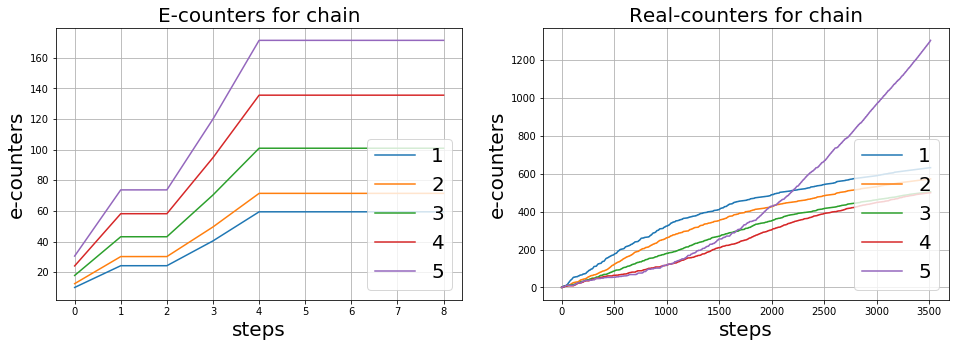

In [12]:
fontsize=20
plt.figure(figsize=(16,5))
plt.subplot(121)
for i in range(dim):
    plt.plot(e_counters[:, i], label='{}'.format(i+1))
plt.grid()
plt.legend(loc='lower right', fontsize=fontsize)
plt.xlabel('steps', fontsize=fontsize)
plt.ylabel('e-counters', fontsize=fontsize)
plt.title('E-counters for chain', fontsize=fontsize)


plt.subplot(122)
for i in range(dim):
    plt.plot(real_counters[:, i], label='{}'.format(i+1))
plt.grid()
plt.legend(loc='lower right', fontsize=fontsize)
plt.xlabel('steps', fontsize=fontsize)
plt.ylabel('e-counters', fontsize=fontsize)
plt.title('Real-counters for chain', fontsize=fontsize)


In [14]:
e_values = e_model.forward(convert_to_var(all_states.sum(axis=1, keepdims=True)-1)).data.numpy()

In [15]:
e_values

array([[2.1232780e-02, 8.9304401e-03],
       [1.3984341e-02, 5.2685635e-03],
       [3.2486012e-03, 8.5752556e-04],
       [5.6657998e-04, 9.8744546e-05],
       [9.3007831e-05, 1.0576643e-05]], dtype=float32)

In [16]:
cnt.sum(axis=1)

array([ 718416.9 ,  812947.94, 1140464.  , 1531249.6 , 1935329.8 ],
      dtype=float32)

In [17]:
real_counters[-1]

array([ 633.,  575.,  505.,  499., 1302.])